In [1]:
library(dagitty)
library(ggplot2)
library(dplyr)
library(gridExtra)
library(broom)
library(knitr)
library(xtable)


Warning message:
"package 'dagitty' was built under R version 4.3.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'gridExtra' was built under R version 4.3.3"

Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine




In [2]:
setwd("C:/Users/Julio/output")

In [3]:
cat("Me imagino a que con el <ejemplo 4 de Lab7> se refieren a la imagen, así que trabajaré con eso ")

Me imagino a que con el <ejemplo 4 de Lab7> se refieren a la imagen, así que trabajaré con eso 

Plot coordinates for graph not supplied! Generating coordinates, see ?coordinates for how to set your own.



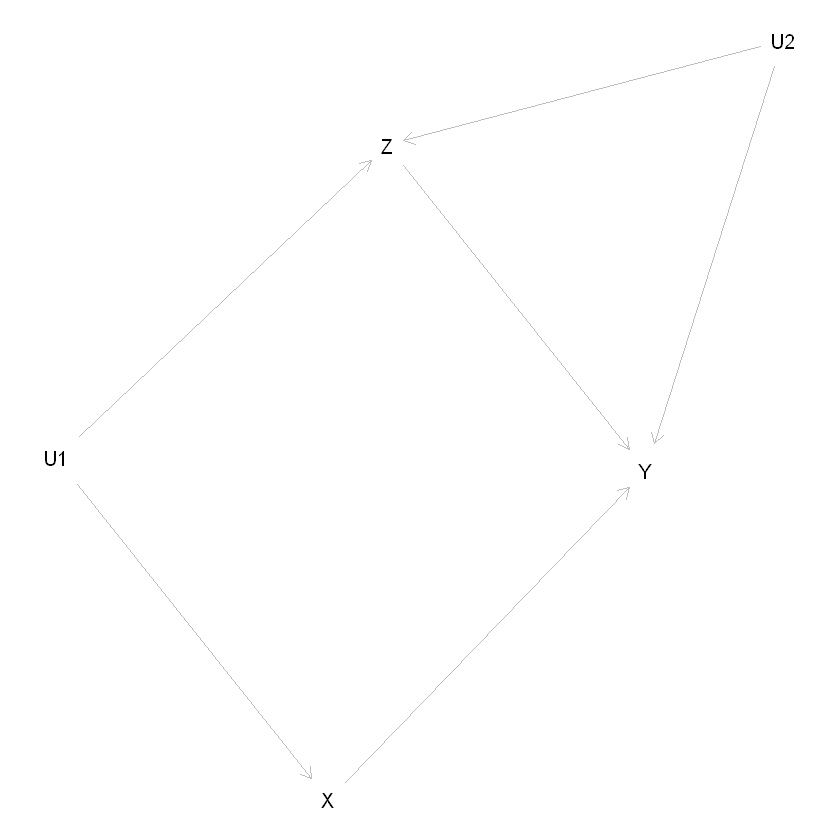

In [6]:
#3.a) El DAG original
#Creamos el DAG
dag_maldito <- dagitty("dag {
    U1 -> X
    U1 -> Z
    Z -> Y
    U2 -> Y
    U2 -> Z
    X -> Y
   
}")

# Visualizar el DAG
plot(dag_maldito, main = "Maldito si lo haces, maldito si no lo haces")

In [7]:
png("Ejemplo4_lab7.png", width = 1000, height = 800, res = 120)
plot(dag_maldito, main = "Maldito si no la haces, pero si lo hice jeje")
dev.off()

Plot coordinates for graph not supplied! Generating coordinates, see ?coordinates for how to set your own.



pdf 
  2

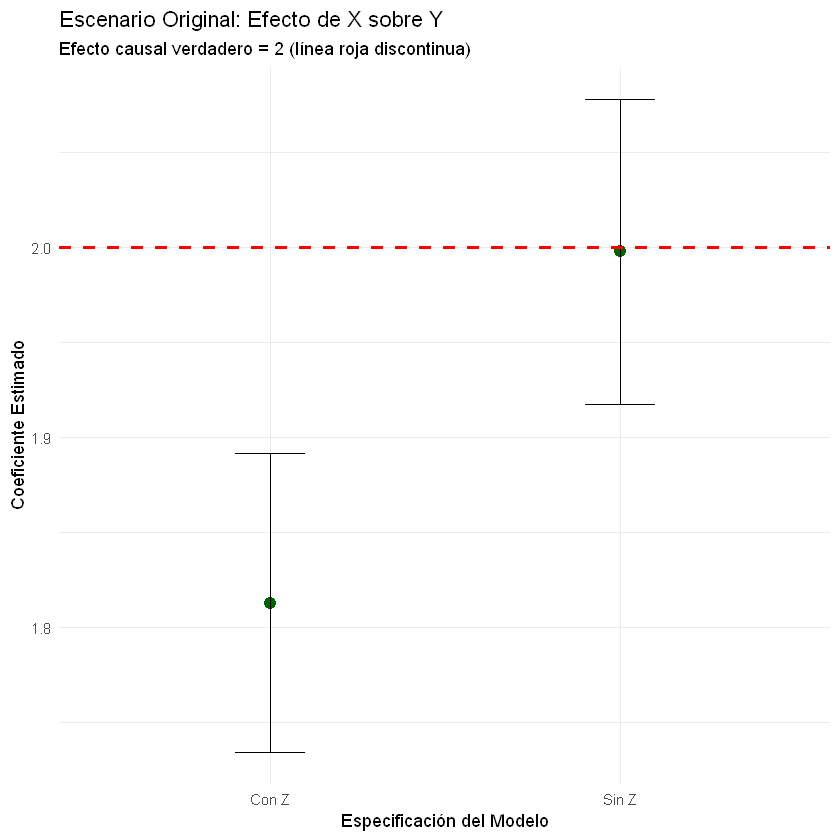

In [9]:
#Graficar
n <- 1000
U1 <- rnorm(n, 0, 1)                    # Variable no observada 1
U2 <- rnorm(n, 0, 1)                    # Variable no observada 2
X <- U1 + rnorm(n, 0, 1)                # X depende de U1
Z <- U1 + U2 + rnorm(n, 0, 1)           # Z es colisionador (depende de U1 y U2)
Y <- 2 * X + U2 + rnorm(n, 0, 1)        # Y depende de X y U2. Efecto verdadero de X sobre Y es 2

# Crear marco de datos
datos_parte3a <- data.frame(Y = Y, X = X, Z = Z, U1 = U1, U2 = U2)

# Regresiones con y sin controlar por Z (el colisionador)
modelo_sin_z <- lm(Y ~ X, data = datos_parte3a)        # Sin controlar Z
modelo_con_z <- lm(Y ~ X + Z, data = datos_parte3a)    # Controlando por Z

# Preparar resultados para graficar
resultados_coef_3a <- data.frame(
    modelo = c("Sin Z", "Con Z"),
    estimacion = c(coef(modelo_sin_z)["X"], coef(modelo_con_z)["X"]),
    conf_inferior = c(confint(modelo_sin_z, "X", level = 0.99)[1], 
                      confint(modelo_con_z, "X", level = 0.99)[1]),
    conf_superior = c(confint(modelo_sin_z, "X", level = 0.99)[2], 
                      confint(modelo_con_z, "X", level = 0.99)[2])
)

# Crear gráfico comparativo
grafico_parte3a <- ggplot(resultados_coef_3a, aes(x = modelo, y = estimacion)) +
    geom_point(size = 3, color = "darkgreen") +
    geom_errorbar(aes(ymin = conf_inferior, ymax = conf_superior), width = 0.2) +
    geom_hline(yintercept = 2, color = "red", linetype = "dashed", size = 1) +
    labs(title = "Escenario Original: Efecto de X sobre Y",
         subtitle = "Efecto causal verdadero = 2 (línea roja discontinua)",
         x = "Especificación del Modelo", y = "Coeficiente Estimado") +
    theme_minimal()

print(grafico_parte3a)
ggsave("grafico_parte3a.png", 
       plot = grafico_parte3a, width = 10, height = 6, dpi = 300, bg = "white")

Plot coordinates for graph not supplied! Generating coordinates, see ?coordinates for how to set your own.



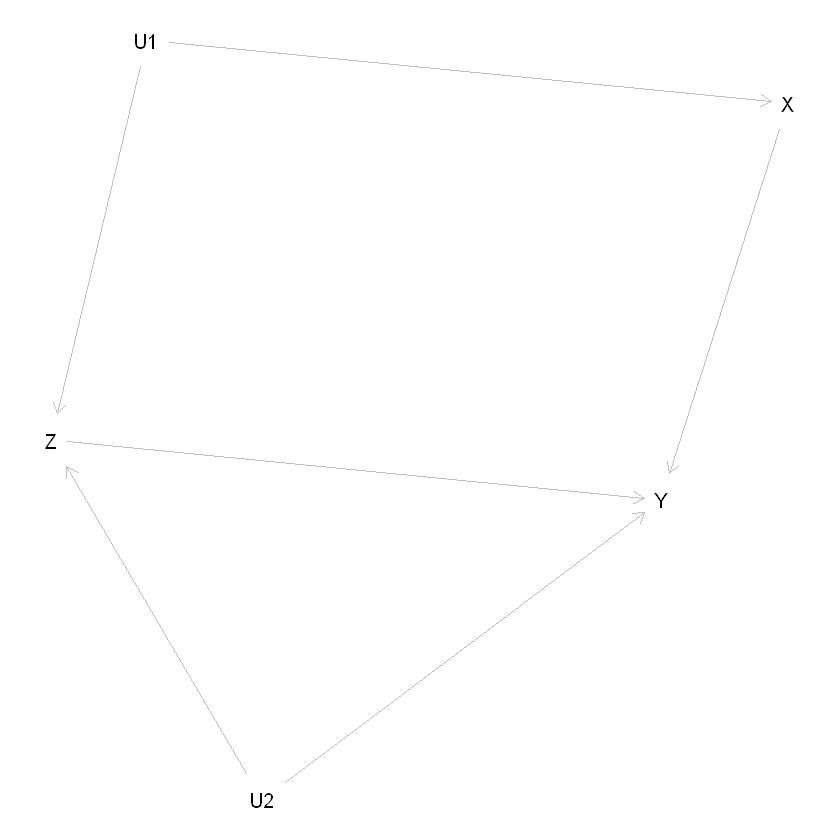

In [10]:
#3.b) DAG Modificado con Z afectando a X
dag_modificado <- dagitty("dag {
    U1 -> X
    U1 -> Z
    Z -> Y
    U2 -> Y
    U2 -> Z
    X -> Y
}")

# Visualizar el DAG modificado
plot(dag_modificado, main = "DAG Modificado: Z afecta a X")

In [19]:
# Simular datos para el escenario modificado
U1_mod <- rnorm(n, 0, 1)                              # Variable no observada 1
U2_mod <- rnorm(n, 0, 1)                              # Variable no observada 2
Z_mod <- U1_mod + U2_mod + rnorm(n, 0, 1)             # Z depende de U1 y U2
X_mod <- U1_mod + 0.5 * Z_mod + rnorm(n, 0, 1)        # X ahora también depende de Z
Y_mod <- 2 * X_mod + U2_mod + rnorm(n, 0, 1)          # Y depende de X y U2. Efecto verdadero sigue siendo 2

# Crear marco de datos modificado
datos_parte3b <- data.frame(Y = Y_mod, X = X_mod, Z = Z_mod, U1 = U1_mod, U2 = U2_mod)

# Generar todas las combinaciones posibles de controles (2^3 = 8 regresiones)
combinaciones_controles <- expand.grid(
    Z = c(FALSE, TRUE),
    U1 = c(FALSE, TRUE), 
    U2 = c(FALSE, TRUE)
)

# Crear matriz para almacenar resultados
matriz_resultados <- matrix(NA, nrow = 8, ncol = 2)
colnames(matriz_resultados) <- c("β", "SE")  # β = coeficiente, EE = Error Estándar

# Crear nombres de filas descriptivos para cada combinación
rownames(matriz_resultados) <- apply(combinaciones_controles, 1, function(x) {
    controles <- names(x)[x == TRUE]
    if(length(controles) == 0) return("Sin controles")
    return(paste(controles, collapse = ", "))
})

# Ejecutar todas las regresiones posibles
for(i in 1:nrow(combinaciones_controles)) {
    # Identificar qué controles incluir en esta iteración
    controles <- names(combinaciones_controles)[combinaciones_controles[i,] == TRUE]
    
    # Construir fórmula de regresión
    if(length(controles) == 0) {
        formula_regresion <- "Y ~ X"
    } else {
        formula_regresion <- paste("Y ~ X +", paste(controles, collapse = " + "))
    }
    
    # Ajustar modelo y extraer coeficiente de X y su error estándar
    modelo <- lm(as.formula(formula_regresion), data = datos_parte3b)
    matriz_resultados[i, 1] <- coef(modelo)["X"]
    matriz_resultados[i, 2] <- summary(modelo)$coefficients["X", "Std. Error"]
}

# Mostrar matriz de resultados
print("MATRIZ DE RESULTADOS")
print(round(matriz_resultados, 4))

# Preparar tabla para exportación
df_resultados <- as.data.frame(matriz_resultados)
df_resultados$Controles <- rownames(matriz_resultados)
df_resultados <- df_resultados[, c("Controles", "β", "SE")]  # Reordenar columnas


[1] "MATRIZ DE RESULTADOS"
                   β     SE
Sin controles 2.1202 0.0228
Z             1.7675 0.0311
U1            2.2896 0.0359
Z, U1         1.9305 0.0400
U2            1.9942 0.0167
Z, U2         1.9901 0.0262
U1, U2        1.9627 0.0282
Z, U1, U2     1.9642 0.0322


In [20]:
print(df_resultados)

                  Controles        β         SE
Sin controles Sin controles 2.120221 0.02276610
Z                         Z 1.767485 0.03109929
U1                       U1 2.289614 0.03586122
Z, U1                 Z, U1 1.930451 0.04000907
U2                       U2 1.994159 0.01671252
Z, U2                 Z, U2 1.990111 0.02617496
U1, U2               U1, U2 1.962692 0.02816534
Z, U1, U2         Z, U1, U2 1.964250 0.03221508


In [23]:
#Analisis de resultados
# Identificar estimaciones más cercanas al efecto verdadero
efecto_verdadero <- 2
desviaciones <- abs(matriz_resultados[,1] - efecto_verdadero)
mejores_estimaciones <- which(desviaciones < 0.1)
print(desviaciones)

Sin controles             Z            U1         Z, U1            U2 
  0.120221032   0.232514815   0.289613559   0.069549410   0.005840687 
        Z, U2        U1, U2     Z, U1, U2 
  0.009888703   0.037307629   0.035750394 


In [25]:
print(mejores_estimaciones)

    Z, U1        U2     Z, U2    U1, U2 Z, U1, U2 
        4         5         6         7         8 


In [26]:
#Exportar df_resultados como .txt
write.table(df_resultados, 
        file = "df_resultados.txt",sep = "\t",row.names = FALSE, col.names = TRUE, quote = FALSE)  

In [ ]:
#Respondemos las últimas preguntas
Respuestas_Preg3 <- "
-Con base en sus hallazgos, ¿de qué manera puede obtener una buena estimación del efecto causal?
Controlando simultáneamente por U1 y U2. Ello bloquea todas las rutas traseras evitando el sesgo del colllider.

-¿Cuál es el conjunto mínimo suficiente de controles para obtener una buena estimación?
Obviamente, U1 y U2 JUNTOS forman el conjunto mínimo suficiente. Controlar solo por Z introduce sesgo por el collider.
Y controlar con U1 o U2 por separado es insuficiente ya que quedan rutas traseras <abiertas>.

-Proporcione intuición sobre por qué puede obtener buenas estimaciones controlando las variables que estableció por encima de 0.1
Sucede que 1 y U2 son las causas comunes que crean confusión, al controlar por ambas, bloqueamos todas las rutas traseras de X a Y.
y como Z es un colisionador,controlarlo abre rutas sesgantes.
Entonces, La combinación U1 + U2 nos da la identificación más limpia. 
"
writeLines(Respuestas_Preg3,"Respuestas_Preg3.md")